# ADA final exam (winter semester 2019/2020)

A friend of yours wants to start a YouTube channel and ideally earn some money via ads. However, there are so many channels and videos out there that your friend has no idea where to even start. Fortunately, they know that you have taken ADA and think you might help them out by analyzing the videos that are currently on YouTube.

The data you are provided with is a subset of YouTube videos, with videos from some of the giant channels in two categories: "Gaming" and "How-to & Style", which are the categories your friend is choosing between. The dataset contains a lot of videos, with data on those videos including their titles, their total number of views in 2019, their tags and descriptions, etc. The data is, in gzip-compressed format, contained in the `data/` folder, as the file `youtube.csv.gz`.

The three tasks A, B and C are **independent** of each other, and you can solve any combination of them. The exam is designed for more than 3 hours, so don't worry if you don't manage to solve everything; you can still score a 6.

You need to run the following two cells to read and prepare the dataset.

In [1]:
import pandas as pd
import numpy as np
from pandasql import sqldf
pysqldf = lambda q: sqldf(q, globals())
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import validation_curve
from sklearn.metrics import mean_absolute_error
from sklearn.preprocessing import Normalizer
from sklearn.linear_model import LogisticRegression
from sklearn.linear_model import Ridge
SEED = 42
import warnings
warnings.filterwarnings('ignore')

In [2]:
youtube = pd.read_csv('data/youtube.csv.gz', compression='gzip')
youtube.upload_date = pd.to_datetime(youtube.upload_date)

In [3]:
youtube.head()

,channel,upload_date,title,tags,duration,view_count,average_rating,height,width,channel_cat
0,PewDiePie,2013-03-04,A NEW ADVENTURE! - Kingdom Hearts (1) w/ Pewds,"['lets', 'play', 'horror', 'game', 'walkthroug...",1126.0,2541550.0,4.886102,720.0,1280.0,Gaming
1,PewDiePie,2013-03-04,SAVING PRIVATE PEWDS - Conker's Bad Fur Day (15),"['lets', 'play', 'horror', 'game', 'walkthroug...",903.0,1727646.0,4.951531,720.0,1280.0,Gaming
2,PewDiePie,2013-03-04,THE WORST SCARE! - Amnesia: Rain (4),"['lets', 'play', 'horror', 'game', 'walkthroug...",806.0,1402747.0,4.962706,720.0,1280.0,Gaming
3,PewDiePie,2013-03-03,Nova / Sp00n / Cry / Pewds - Worms Revolution ...,"['lets', 'play', 'horror', 'game', 'walkthroug...",909.0,4348296.0,4.937665,720.0,1280.0,Gaming
4,PewDiePie,2013-03-03,SEXIEST HORROR EVER - Amnesia: Rain (3),"['lets', 'play', 'horror', 'game', 'walkthroug...",834.0,1410659.0,4.957545,720.0,1280.0,Gaming


## Dataset description

Each row of the dataset corresponds to one video that was uploaded to YouTube. There are 11 columns:
'channel', 'upload_date', 'title', 'categories', 'tags', 'duration',
       'view_count', 'average_rating', 'height', 'width', 'channel_cat'.
- `channel`: The channel (account) on which the video was uploaded.
- `upload_date`: The date on which the video was uploaded (Pandas Timestamp object).
- `title`: The title of the video.
- `tags`: A list of words that describe the video.
- `duration`: The duration of the video in seconds.
- `view_count`: The number of times the video was watched.
- `average_rating`: The average score with which the viewers rated the video (1-5).
- `height`: The height of the video in pixels.
- `width`: The width of the video in pixels.
- `channel_cat`: The category of the channel on which this video was uploaded. This dataset only contains videos from channels from the 'Gaming' and the 'Howto & Style' category.

# Task A: Welcome to the exam!

All of Task A refers to the videos that were published between and including 2010 and 2018.

## A1: A growing platform?

You would first like to know whether YouTube in general is the right platform to invest time into.

1. Using the appropriate plot type, plot the number of videos published per year between and including 2010 and 2018.

In [4]:
youtube_by_year = youtube.copy()
youtube_by_year['upload_date'] = youtube_by_year['upload_date'].dt.year
youtube_by_year.head()

,channel,upload_date,title,tags,duration,view_count,average_rating,height,width,channel_cat
0,PewDiePie,2013,A NEW ADVENTURE! - Kingdom Hearts (1) w/ Pewds,"['lets', 'play', 'horror', 'game', 'walkthroug...",1126.0,2541550.0,4.886102,720.0,1280.0,Gaming
1,PewDiePie,2013,SAVING PRIVATE PEWDS - Conker's Bad Fur Day (15),"['lets', 'play', 'horror', 'game', 'walkthroug...",903.0,1727646.0,4.951531,720.0,1280.0,Gaming
2,PewDiePie,2013,THE WORST SCARE! - Amnesia: Rain (4),"['lets', 'play', 'horror', 'game', 'walkthroug...",806.0,1402747.0,4.962706,720.0,1280.0,Gaming
3,PewDiePie,2013,Nova / Sp00n / Cry / Pewds - Worms Revolution ...,"['lets', 'play', 'horror', 'game', 'walkthroug...",909.0,4348296.0,4.937665,720.0,1280.0,Gaming
4,PewDiePie,2013,SEXIEST HORROR EVER - Amnesia: Rain (3),"['lets', 'play', 'horror', 'game', 'walkthroug...",834.0,1410659.0,4.957545,720.0,1280.0,Gaming


In [5]:
query = """SELECT upload_date AS year, COUNT(DISTINCT title) AS number_of_videos FROM youtube_by_year GROUP BY upload_date;"""
youtube_by_year = pysqldf(query)

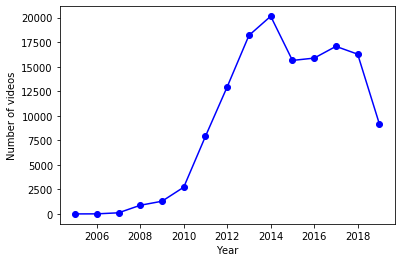

In [6]:
#plt.bar(youtube_by_year['year'],youtube_by_year['number_of_videos'])
plt.plot(youtube_by_year['year'],youtube_by_year['number_of_videos'], 'bo-')
plt.xlabel('Year')
plt.ylabel('Number of videos')
plt.show()

2. Now for each year, plot the number of channels that have been created between the beginning of 2010 and the end of that year. A channel is considered to be created at the time at which they upload their first video.

In [7]:
youtube_by_channel = youtube.copy()
#select the year only from the timestamps
youtube_by_channel['upload_date'] = youtube_by_channel['upload_date'].dt.year
#create a dataframe of channels and their year of creation
query = """SELECT channel, MIN(upload_date) AS year_creation FROM youtube_by_channel GROUP BY channel;"""
channels = pysqldf(query)
#group by year of creation to compute the count at each year
query = """SELECT year_creation, COUNT(channel) AS nbr_channels FROM channels WHERE year_creation>=2010 GROUP BY year_creation;"""
channels = pysqldf(query)
channels

,year_creation,nbr_channels
0,2010,21
1,2011,26
2,2012,34
3,2013,21
4,2014,18
5,2015,13
6,2016,12
7,2017,17
8,2018,2


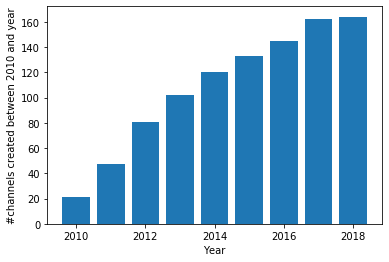

In [8]:
#compute cumulative sum over years
channels['nbr_channels'] = np.cumsum(channels['nbr_channels'])

#plot the cumulative sum
#plt.plot(channels['year_creation'],channels['nbr_channels'], 'bo-')
plt.bar(channels['year_creation'],channels['nbr_channels'])
plt.xlabel('Year')
plt.ylabel('#channels created between 2010 and year')
plt.show()

3. Normalize the number of videos published each year by the number of channels that have been created between the beginning of 2010 and the end of that year, and plot these quantities. Do seperate plots for gaming channels, how-to channels, and both together. Can you conclude from the plot that both gaming and how-to channels have been becoming less and less active recently? Why, or why not?

In [9]:
normalized_count = youtube_by_year.copy()
normalized_count = normalized_count[normalized_count['year']>=2010]
normalized_count = channels.merge(normalized_count, left_on='year_creation', right_on='year')
normalized_count['number_of_videos']=normalized_count['number_of_videos']/normalized_count['nbr_channels']

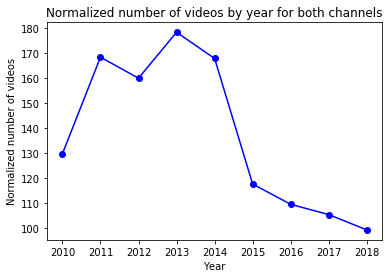

In [10]:
#plt.bar(youtube_by_year['year'],youtube_by_year['number_of_videos'])
plt.plot(normalized_count['year'],normalized_count['number_of_videos'], 'bo-')
plt.xlabel('Year')
plt.ylabel('Normalized number of videos')
plt.title('Normalized number of videos by year for both channels')
plt.show()

### Gaming channel

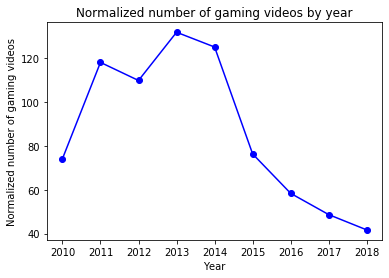

In [11]:
#we use the same workflow as above
gaming_by_year = youtube.copy()
gaming_by_year = gaming_by_year[gaming_by_year['channel_cat'] == 'Gaming']
gaming_by_year['upload_date'] = gaming_by_year['upload_date'].dt.year
query = """SELECT upload_date AS year, COUNT(DISTINCT title) AS number_of_videos FROM gaming_by_year GROUP BY upload_date;"""
gaming_by_year = pysqldf(query)

gaming_by_channel = youtube.copy()
gaming_by_channel['upload_date'] = gaming_by_channel['upload_date'].dt.year
query = """SELECT channel, MIN(upload_date) AS year_creation FROM gaming_by_channel GROUP BY channel;"""
gaming_channels = pysqldf(query)
query = """SELECT year_creation, COUNT(channel) AS nbr_channels FROM gaming_channels WHERE year_creation>=2010 GROUP BY year_creation;"""
gaming_channels = pysqldf(query)
gaming_channels['nbr_channels'] = np.cumsum(gaming_channels['nbr_channels'])

normalized_count = gaming_by_year.copy()
normalized_count = normalized_count[normalized_count['year']>=2010]
normalized_count = gaming_channels.merge(normalized_count, left_on='year_creation', right_on='year')
normalized_count['number_of_videos']=normalized_count['number_of_videos']/normalized_count['nbr_channels']

plt.plot(normalized_count['year'],normalized_count['number_of_videos'], 'bo-')
plt.xlabel('Year')
plt.ylabel('Normalized number of gaming videos')
plt.title('Normalized number of gaming videos by year')
plt.show()

###  How-to channel

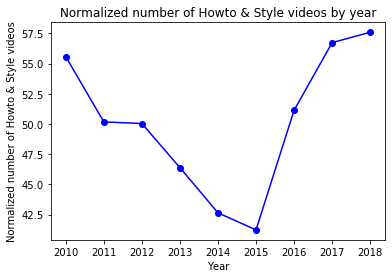

In [12]:
#we use the same workflow as above
howto_by_year = youtube.copy()
howto_by_year = howto_by_year[howto_by_year['channel_cat'] == 'Howto & Style']
howto_by_year['upload_date'] = howto_by_year['upload_date'].dt.year
query = """SELECT upload_date AS year, COUNT(DISTINCT title) AS number_of_videos FROM howto_by_year GROUP BY upload_date;"""
howto_by_year = pysqldf(query)

howto_by_channel = youtube.copy()
howto_by_channel['upload_date'] = howto_by_channel['upload_date'].dt.year
query = """SELECT channel, MIN(upload_date) AS year_creation FROM howto_by_channel GROUP BY channel;"""
howto_channels = pysqldf(query)
query = """SELECT year_creation, COUNT(channel) AS nbr_channels FROM howto_channels WHERE year_creation>=2010 GROUP BY year_creation;"""
howto_channels = pysqldf(query)
howto_channels['nbr_channels'] = np.cumsum(howto_channels['nbr_channels'])

normalized_count = howto_by_year.copy()
normalized_count = normalized_count[normalized_count['year']>=2010]
normalized_count = howto_channels.merge(normalized_count, left_on='year_creation', right_on='year')
normalized_count['number_of_videos']=normalized_count['number_of_videos']/normalized_count['nbr_channels']

plt.plot(normalized_count['year'],normalized_count['number_of_videos'], 'bo-')
plt.xlabel('Year')
plt.ylabel('Normalized number of Howto & Style videos')
plt.title('Normalized number of Howto & Style videos by year')
plt.show()

* We you conclude from the plots that the gaming channels have been becoming less and less active since 2014
* However the Howto & Style channels are becoming more and more active since 2015
* The sum of the two gives a decreasing curve because the decrease rate of activity of gaming channels is a lot more important than the increase rate of the Howto & Style channels.

## A2: The one thing we all love: cash money

Your friend is really keen on making money from their YouTube channel through ads and wants you to help them choose the most profitable channel category (Gaming or Howto & Style). The ad profit is directly proportional to the number of views of a video.

1. Since your friend wants to keep producing videos for several years to come, it might also be worth looking at the growth of the two categories.
  1. Compute the total number of views in each category per year for the years 2010-2018.
  2. Divide the yearly view count by the number of channels that posted a video in each category in each year. Plot these normalized counts.




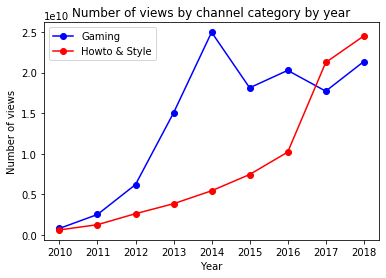

In [13]:
#gaming channels
gaming_by_year = youtube.copy()
gaming_by_year = gaming_by_year[gaming_by_year['channel_cat'] == 'Gaming']
gaming_by_year['upload_date'] = gaming_by_year['upload_date'].dt.year
gaming_by_year = gaming_by_year[gaming_by_year['upload_date']>=2010]
gaming_by_year = gaming_by_year[gaming_by_year['upload_date']<=2018]
query = """SELECT upload_date AS year, SUM(view_count) AS number_of_views FROM gaming_by_year GROUP BY upload_date;"""
gaming_by_year = pysqldf(query)
#Howto channels
howto_by_year = youtube.copy()
howto_by_year = howto_by_year[howto_by_year['channel_cat'] == 'Howto & Style']
howto_by_year['upload_date'] = howto_by_year['upload_date'].dt.year
howto_by_year = howto_by_year[howto_by_year['upload_date']>=2010]
howto_by_year = howto_by_year[howto_by_year['upload_date']<=2018]
query = """SELECT upload_date AS year, SUM(view_count) AS number_of_views FROM howto_by_year GROUP BY upload_date;"""
howto_by_year = pysqldf(query)

plt.plot(gaming_by_year['year'],gaming_by_year['number_of_views'], 'bo-', label="Gaming")
plt.plot(howto_by_year['year'],howto_by_year['number_of_views'], 'ro-', label="Howto & Style")
plt.xlabel('Year')
plt.legend()
plt.ylabel('Number of views')
plt.title('Number of views by channel category by year')
plt.show()

In [14]:
# gaming channels that published a video each year
gaming= youtube.copy()
gaming['upload_date'] = gaming['upload_date'].dt.year
query = """SELECT channel, COUNT(DISTINCT upload_date) AS years_activity FROM gaming WHERE channel_cat='Gaming' AND upload_date>=2010 AND upload_date<=2018 GROUP BY channel HAVING years_activity=9;"""
gaming_channels = pysqldf(query)
gaming_channels.head()

,channel,years_activity
0,Call of Duty,9
1,JonTronShow,9
2,League of Legends,9
3,Rockstar Games,9
4,The Game Theorists,9


In [15]:
# howto channels that published a video each year
howto= youtube.copy()
howto['upload_date'] = howto['upload_date'].dt.year
query = """SELECT channel, COUNT(DISTINCT upload_date) AS years_activity FROM gaming WHERE channel_cat='Howto & Style' AND upload_date>=2010 AND upload_date<=2018 GROUP BY channel HAVING years_activity=9;"""
howto_channels = pysqldf(query)
howto_channels.head()

,channel,years_activity
0,ATHLEAN-X™,9
1,FitnessBlender,9
2,Ingrid Nilsen,9
3,Kandee Johnson,9
4,Krazyrayray,9


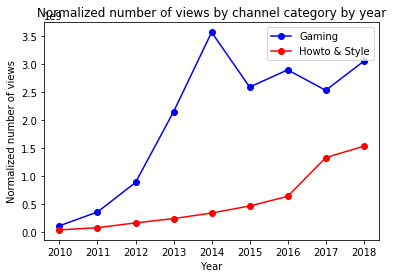

In [16]:
gaming_by_year['number_of_views'] = gaming_by_year['number_of_views'] / len(gaming_channels)
howto_by_year['number_of_views'] = howto_by_year['number_of_views'] / len(howto_channels)
plt.plot(gaming_by_year['year'],gaming_by_year['number_of_views'], 'bo-', label="Gaming")
plt.plot(howto_by_year['year'],howto_by_year['number_of_views'], 'ro-', label="Howto & Style")
plt.xlabel('Year')
plt.legend()
plt.ylabel('Normalized number of views')
plt.title('Normalized number of views by channel category by year')
plt.show()

2. Your friend's channel will be brand new, so you decide to look more closely at newer channels. For this question and all the following questions in A2, only consider channels that uploaded their first video in  2016 or later. Compute the total number of views in each category and divide it by the number of channels in that category.


In [17]:
#gaming channels
gaming_by_year = youtube.copy()
gaming_by_year = gaming_by_year[gaming_by_year['channel_cat'] == 'Gaming']
gaming_by_year['upload_date'] = gaming_by_year['upload_date'].dt.year
gaming_by_year = gaming_by_year[gaming_by_year['upload_date']>=2016]
gaming_by_year = gaming_by_year[gaming_by_year['upload_date']<=2018]
query = """SELECT upload_date AS year, SUM(view_count) AS number_of_views FROM gaming_by_year GROUP BY upload_date;"""
gaming_by_year = pysqldf(query)
#Howto channels
howto_by_year = youtube.copy()
howto_by_year = howto_by_year[howto_by_year['channel_cat'] == 'Howto & Style']
howto_by_year['upload_date'] = howto_by_year['upload_date'].dt.year
howto_by_year = howto_by_year[howto_by_year['upload_date']>=2016]
howto_by_year = howto_by_year[howto_by_year['upload_date']<=2018]
query = """SELECT upload_date AS year, SUM(view_count) AS number_of_views FROM howto_by_year GROUP BY upload_date;"""
howto_by_year = pysqldf(query)

In [18]:
# number of channels in category gaming
gaming= youtube.copy()
gaming['upload_date'] = gaming['upload_date'].dt.year
query = """SELECT COUNT(DISTINCT channel) AS nbr_channels FROM gaming WHERE channel_cat='Gaming' AND upload_date>=2016 AND upload_date<=2018;"""
gaming_channels = pysqldf(query)
gaming_channels = gaming_channels['nbr_channels'][0]

In [19]:
# number of channels in category gaming
howto= youtube.copy()
howto['upload_date'] = howto['upload_date'].dt.year
query = """SELECT COUNT(DISTINCT channel) AS nbr_channels FROM howto WHERE channel_cat='Howto & Style' AND upload_date>=2016 AND upload_date<=2018;"""
howto_channels = pysqldf(query)
howto_channels = howto_channels['nbr_channels'][0]

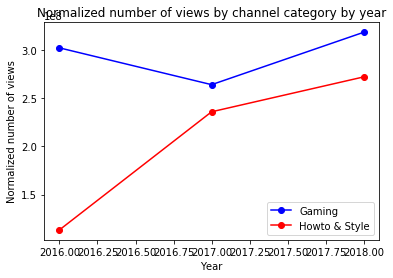

In [20]:
gaming_by_year['number_of_views'] = gaming_by_year['number_of_views'] / gaming_channels
howto_by_year['number_of_views'] = howto_by_year['number_of_views'] / howto_channels
plt.plot(gaming_by_year['year'],gaming_by_year['number_of_views'], 'bo-', label="Gaming")
plt.plot(howto_by_year['year'],howto_by_year['number_of_views'], 'ro-', label="Howto & Style")
plt.xlabel('Year')
plt.legend()
plt.ylabel('Normalized number of views')
plt.title('Normalized number of views by channel category by year')
plt.show()

3. The number of views might be very unevenly over the different channels, and channels might upload different numbers of videos.
  1. Compute the mean number of views per video for each channel.
  2. Compute the mean of these means for each of the two categories. Print these values.
  3. Using bootstrapping, compute 95% confidence intervals for these two means. From this analysis, can you draw a recommendation for one of the two categories? Why, or why not?

# Task B: View forecasting (Machine Learning)

Your friend wants to figure out how they can optimize their videos for getting the maximum number of views (without using shocking thumbnails and clickbait titles). In this task, you will build a machine learning (ML) model for predicting the success of a video.

## B1: Get those shovels out again

1. For the prediction model, use all rows of the dataset, but keep only the following columns: `view_count, channel, upload_date, duration, average_rating, height, width`.

In [21]:
columns = ['view_count', 'channel', 'upload_date', 'duration', 'average_rating', 'height', 'width']
X = youtube.copy()
X = X[columns]

2. Extract the upload year and upload month from the `upload_date` column into the two columns `upload_year` and `upload_month`, and remove `upload_date`.

In [22]:
X['year'] = X['upload_date'].dt.year
X['month'] = X['upload_date'].dt.month
X.drop('upload_date', axis=1,inplace=True)

3. The entry in the channel column for a video indicates on which channel the video was uploaded. Encode this column via one-hot encoding.

In [23]:
# Get one hot encoding of columns B
one_hot = pd.get_dummies(X['channel'])
# Drop column B as it is now encoded
X.drop('channel',axis = 1,inplace=True)
# Join the encoded df
X = X.join(one_hot)

4. Split the data into a train (70%) and a test set (30%) with the appropriate function from sklearn, using 42 as the random seed.

In [24]:
X_train, X_test = train_test_split(X, test_size=0.3, random_state=SEED)

## B2: Who is the most viewed of them all?

1. Train a ridge regression model (i.e., an L2-regularized linear regression model) on the train set that predicts the view count from the other features. Find and use the optimal regularization parameter $\alpha$ from the set {0.001, 0.01, 0.1} via 3-fold cross validation.

In [25]:
y_train = X_train['view_count']
X_train.drop('view_count',axis = 1,inplace=True)
y_test = X_test['view_count']
X_test.drop('view_count',axis = 1,inplace=True)

In [26]:
#Normalize the features
transformer = Normalizer().fit(X_train)
X_train_norm = transformer.transform(X_train)
X_test_norm = transformer.transform(X_test)

In [27]:
alphas    =[0.001, 0.01, 0.1]
model     = Ridge(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train_norm, y_train,\
                                                   param_name = "alpha", param_range = alphas,\
                                                   cv=cv_schema)

In [28]:
cv_scores_mean = np.mean(cv_scores_val, axis=1)

In [29]:
np.argmin(cv_scores_mean)

0

* Best value is alpha = 0.001

In [30]:
clf = Ridge(alpha=0.001).fit(X_train_norm, y_train)

2. Report the mean absolute error that the model makes on the test set.

In [31]:
y_pred = clf.predict(X_test_norm)
mean_absolute_error(y_test, y_pred)

1737436.4462618874

## B3: Checking our ambitions

To improve performance, you want to make the task of the ML model easier and turn it into a classification task. Now it only has to predict whether a video has a high view count (defined as being larger than the median of the view counts in the training set) or a low view count (defined as being smaller or equal to the median of the view counts in the training set).

1. Train a logistic regression model for this classification task. Find and use the optimal regularization parameter C (as defined in scikit-learn's documentation) from the set {1, 10, 100} via 3-fold cross validation. Use the random seed 42. _Hint_: If you get a warning about the training algorithm failing to converge, increase the maximum number of training iterations.

In [32]:
median = np.median(y_train)
y_train = [1 if x>=median else 0 for x in y_train]
y_test = [1 if x>=median else 0 for x in y_test]

In [33]:
c_values    =[1, 10, 100]
model     = LogisticRegression(random_state=SEED)
cv_schema = StratifiedKFold(n_splits=3, random_state=SEED)

train_scores_val, cv_scores_val = validation_curve(model, X_train_norm, y_train,\
                                                   param_name = "C", param_range = c_values,\
                                                   cv=cv_schema)

2. Compute the accuracy of the logistic regression model on the test set.

## B4: ...something's not right.

You are satisfied with the model performance. In fact, you are a bit surprised at how good the model is given the relatively little amount of information about the videos. So you take a closer look at the features and realize that the (one-hot-encoded) channel feature does not make sense for the application that your friend has in mind.

1. Why does the channel feature not make sense?

2. Train another logistic regression model with all the features from B3 except the one-hot-encoded channel. Use again 42 as the seed for the train test split and perform the same hyperparameter optimization as in B3. How does the model performance change?

## B5: "We kinda forgot about categories."

On second thought, there is actually one feature that you may use about the channel. Namely, the channel category. The reason this one makes sense might also help you answer B4.1.

1. Train and evaluate another logistic regression model (in the same way as in B4 regarding train/test split and hyperparameter) that additionally includes the one-hot-encoded channel category.

2. The dynamics of the two categories might differ a lot, and the two communities might value different properties of a video differently. For instance, for one community, a long duration might be more important, for the other one, a large picture width. Thus, having only a single weight for, e.g., the duration of a video, might not give the best results. Is there something smarter that you can do than simply including the category as a single one-hot-encoded feature to improve the classification performance? Implement your idea and compare the accuracy on the test set with that of the first model (from task B5.1).

# Task C: A map of the channels (Graphs)

Your friend wants to map out the channels and represent their similarities. For this purpose, we have created two undirected and unweighted graphs for you, where in each graph, each channel has a node and similar channels have edges connecting them. In one graph, the similarity between two channels is based on how similar their video descriptions are, while in the other, the similarity is based on how similar their video tags are. We will call the former $G_{text}$ and the latter $G_{tags}$. You will be analyzing the two graphs loaded by running the cell below.

In [ ]:
from networkx import from_numpy_array
import json
g_text_adj = np.loadtxt(open('data/g_text_adj.csv', 'r'), delimiter=',', skiprows=0)
g_tags_adj = np.loadtxt(open('data/g_tags_adj.csv', 'r'), delimiter=',', skiprows=0)
channel_to_index = json.load(open('data/channel_indices.json', 'r'))
g_text = from_numpy_array(g_text_adj)
g_tags = from_numpy_array(g_tags_adj)

## C1: Does YouTube have a content diversity problem?

1. For each graph, calculate its diameter (i.e., the largest shortest-path length, where the maximization is done over all node pairs). What difference do you see? _Hint_: Don't worry if you get an error, just read the error message carefully.

2. What does the diameter of $G_{text}$ say about the diversity of the channels’ contents? How about the diameter of $G_{tags}$?

3. Based on what you have calculated, which one has greater diversity: descriptions used by channels, or tags used by channels? Justify your answer.

4. Imagine that you want to **compare** content diversity between two sets of channels (i.e., you want to see which set of channels has more diverse content), and you have calculated a tag-based graph for each set. Do you think the diameter is a good measure for doing the comparison? Justify your answer.

5. Back to our own two graphs. Based on $G_{text}$, for each category of channels, which channel is the one most representative of the contents of all channels in that category? In other words, for each category, if you needed to provide a summary of all channels in the category via one channel, which channel would you choose? Show us (us being the exam designers and your friend) the descriptions of this channel’s two most-viewed videos. What metric did you use for this purpose? Explain your choice.

## C2: Going back to categories again

1. We want to use the two graphs to cluster channels from the same category together, and we want to compare their effectiveness at doing so. Use Kernighan-Lin bisection in the networkx package (`networkx.algorithms.community.kernighan_lin_bisection`) to divide each graph into two communities. Use 42 as the random seed. For each graph, show how many members of each category fall into each of the two communities.

2. If one of these graphs were ideal for this clustering task, what would the resulting communities look like? If it were the absolute worst possible graph for the task, what would the resulting communities look like?

3. Calculate the probability $P(community|category)$ for each community and category within each graph. Design a metric, using the four $P(community|category)$ values in a graph, whose value would be 1 for the ideal graph and 0 for the worst graph. Calculate this metric for both graphs and compare the two. What do the results say about how representative tags and descriptions are regarding the channel categories? Are tags better suited, or descriptions?

4. The Kernighan-Lin bisection you used above performs a min-edge cut: It attempts to partition the nodes of the graph into two sets of almost-equal size by deleting as few edges as possible. It starts off by creating a random partition of the nodes of the graph into two sets A and B that are almost equal in size, and then iteratively and in a greedy fashion moves nodes between A and B to reduce the number of edges between A and B. Show at least one toy example of a graph where the initialization could also be the final result. (Hint: Think of how, as we explained, the bisection algorithm relies on a minimum edge cut with a random initialization; under what circumstances could the original A and B be the best partition given that graph?)